# Behavioural data

All statistical analyses of the behavioural data were performed using R (v3.6.0, 2019-04-26) in RStudio (v1.2.1335, RStudio, Inc, Boston, MA). The significance threshold for all statistical comparisons was p < 0.05. 

In [1]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.0                         
year           2019                        
month          04                          
day            26                          
svn rev        76424                       
language       R                           
version.string R version 3.6.0 (2019-04-26)
nickname       Planting of a Tree          

In [12]:
# Dace Apšvalka @MRC CBU, 2019
# ----------------------------------------------------------------------
# LIBRARIES
# ----------------------------------------------------------------------
library(Hmisc, warn.conflicts = FALSE) 
library(plyr)      # for ddply (aggregating SST results)
library(pastecs)   # for summary statistic
library(ggplot2)   # for plotting results
library(repr)      # for changing plot size (default too large in notebook)
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(aplpack)   # for bi-variate outlier, bgplot
library(robust)    # for robust correlation

# ----------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------

# 1. STOP-SIGNAL ANALYSIS
# Based on: Verbruggen et al (2019). https://doi.org/10.7554/eLife.46323.001
# ------------------------------------
funcSignal <- function(data) {
  # all trials with a Response (any)
  data$resp <- ifelse(data$gRT == "0", 0, 1)
  
  # Stop-signal trials
  # ----------------------------------------------------------------------
  # All
  signal <- subset(data, gkind == '1')
  # probability of responding to the Stop-Signal
  presp <-  mean(signal$resp)
  # mean Stop-Signal Delay (of all Stop-Signal trials)
  ssd <- mean(signal$gintVal)
  # unsuccessful Stop RTs
  signal.resp    <- subset(signal, resp == '1')
  signal.resp.rt <- mean(signal.resp$gRT)
  
  # Go trials
  # ----------------------------------------------------------------------
  # All
  nosignal <- subset(data, gkind == '0') 
  # With response
  nosignal_resp <- subset(nosignal, resp == '1') 
  # probability of Go omossions
  pmiss <- 1-mean(nosignal$resp)
  # Correct Go
  nosignal_resp$error <-
    ifelse(nosignal_resp$gtheButton == nosignal_resp$gresp, 0, 1)
  # Probability of error on responded Go trials
  perror <- mean(nosignal_resp$error)
  # for the missed responses, set RT to max RT of the subject
  nosignal$gRT <-
    ifelse(nosignal$gRT == 0, max(nosignal_resp$gRT), nosignal$gRT)
  # RT for Go trials with a response
  nosignal.resp.rt <- mean(nosignal_resp$gRT)
  # RT for correct Go trials
  nosignal.correctresp <- subset(nosignal_resp, error == '0')
  nosignal.correctresp.rt <- mean(nosignal.correctresp$gRT)
  
  # SSRT
  # ----------------------------------------------------------------------
  # All Go trials are included when the nth RT is determined
  ## determine nth RT
  nthRT_all <- quantile(nosignal$gRT, probs = presp, type = 6)
  ## SSRT(integration) = nthRT - ssd
  SSRTall <- nthRT_all - ssd
  
  # Race Check
  # ----------------------------------------------------------------------
  # All Go trials
  race.check <- nosignal.resp.rt - signal.resp.rt
  # Using correct Go only
  race.checkCorrGo <- nosignal.correctresp.rt - signal.resp.rt
  
  # Output
  # ----------------------------------------------------------------------
  return(
    data.frame(
      total = nrow(data),
      signal = sum(signal$gkind),
      ssPerc = sum(signal$gkind)/nrow(data)*100,
      presp, pmiss, perror, ssd,
      SSRT = SSRTall,
      sRT = signal.resp.rt,
      goRT = nosignal.resp.rt,
      raceCheck = race.check,
      raceCheckCorrGo = race.checkCorrGo
    )
  )
}

# 2. PLOTTING MEANS, Group mean (with 95%CI) and subject values
# ------------------------------------
plotResults <- function(dataset, x, group, title, units, extraTxt) {
  ggplot(dataset, aes(group, x)) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = 1, stroke = 0.1, shape = 21,
      position = position_jitter(height = 0, width = 0.1)
    ) +
    stat_summary(
      fun.data = mean_cl_boot,
      geom = "pointrange",
      fill = 'red', alpha = 0.8, color = "black",
      size = 0.6, stroke = 0.3, shape = 21,
      position = position_nudge(x = -0.2)
    ) +
    scale_x_discrete() +
    labs(x = extraTxt, y = units) + ggtitle(title) +
    theme_minimal() +
    theme(text = element_text(size = 9), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

# 3. PLOTTING CORRELATIONS (with 95%CI)
# ------------------------------------
plotCorrelation <- function(dataset, x, y, xLabel, yLabel, resTXT, pointsize, txtsize) {
  ggplot(dataset, aes(x, y)) +
    geom_smooth(
      method = lm, level = 0.95,
      color = "black", fill = "grey", size = 0.2
    ) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = pointsize, stroke = 0.2, shape = 21
    ) +
    labs(x = xLabel, y = yLabel) + ggtitle(resTXT) + 
    theme_minimal() + 
    theme(text = element_text(size = txtsize), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

Data are available online ... 

In [3]:
# ----------------------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------------------

# SST
dataSST <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/SSTraw.csv')
# exclude Go only runs from the analysis
dataSST <- subset(dataSST, cond == '2') 

# TNT
dataTNT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TNT.csv')
# turn test values into percentages
dataTNT[, 10:ncol(dataTNT)] <- dataTNT[, 10:ncol(dataTNT)] * 100

# SST data
SST data were analaysed ... 

In [4]:
# ======================================================================
# SST RESULTS
# ======================================================================
# By Subject aggregated
# ----------------------------------------------------------------------
dataSSTsubj <- ddply(dataSST, .(sNR), funcSignal)

# Get descriptives
# ----------------------------------------------------------------------
dscrSST <- stat.desc(dataSSTsubj[, 4:ncol(dataSSTsubj)],  basic = FALSE, desc = TRUE, p = 0.95) 
options(width = 120)
print(dscrSST)

                  ssPerc       presp        pmiss       perror          ssd         SSRT          sRT         goRT
median       31.90104167 0.495967480 0.0000000000 0.0379672056  231.5341110  349.0330882  549.0919294 6.001717e+02
mean         31.88864087 0.488047588 0.0024094899 0.0403434370  229.9959663  348.3445353  556.9230396 6.016693e+02
SE.mean       0.35875745 0.015097003 0.0011492589 0.0049907994    7.2838576   10.4603705   11.5876987 1.152381e+01
CI.mean.0.95  0.74214633 0.031230530 0.0023774231 0.0103242552   15.0678075   21.6389250   23.9709810 2.383881e+01
var           3.08896581 0.005470068 0.0000316991 0.0005977939 1273.3099660 2626.0644125 3222.5942519 3.187154e+03
std.dev       1.75754539 0.073959909 0.0056301957 0.0244498240   35.6834691   51.2451404   56.7678981 5.645489e+01
coef.var      0.05511509 0.151542412 2.3366753601 0.6060421660    0.1551482    0.1471105    0.1019313 9.383042e-02
               raceCheck raceCheckCorrGo
median        43.8776353       41.30466

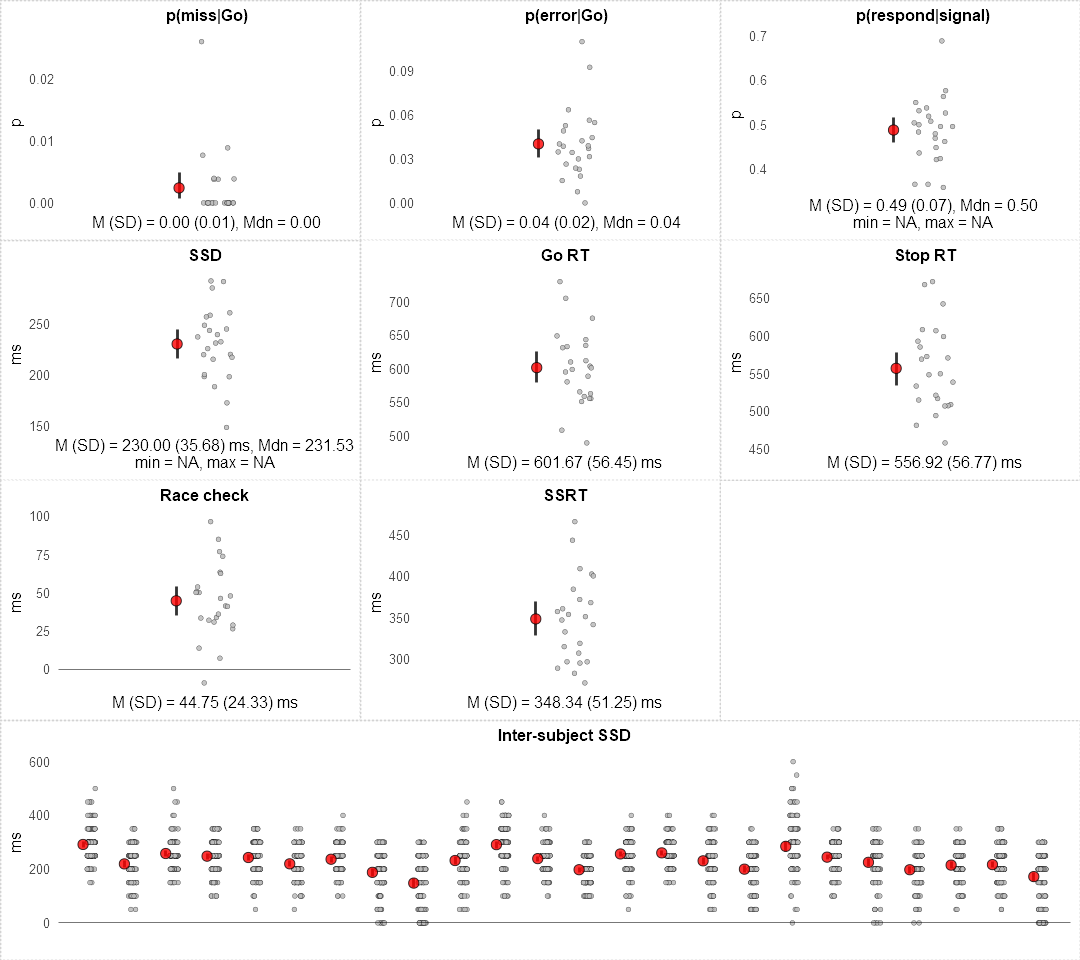

In [5]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 9, repr.plot.height = 8) 
# 1. Probability of Go omissions (no response)
p1 <- plotResults(dataSSTsubj, dataSSTsubj$pmiss, 1, "p(miss|Go)", "p", 
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","pmiss"], dscrSST["std.dev","pmiss"], dscrSST["median","pmiss"]))
# 2. Probability of choice errors on Go trials
p2 <- plotResults(dataSSTsubj, dataSSTsubj$perror, 1, "p(error|Go)", "p",
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","perror"], dscrSST["std.dev","perror"], dscrSST["median","perror"]))
# 3. Probability of responding on a Stop trial
# recommended to refrain from estimating individual SSRTs when p (respond|signal) is lower than 0.25 or higher than 0.75
p3 <- plotResults(dataSSTsubj, dataSSTsubj$presp, 1, "p(respond|signal)", "p",
                    sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","presp"], dscrSST["std.dev","presp"], dscrSST["median","presp"], 
                            dscrSST["min","presp"], dscrSST["max","presp"]))
# 4. Average Stop-Signal Delay
p4 <- plotResults(dataSSTsubj, dataSSTsubj$ssd, 1, "SSD", "ms",
                    sprintf("M (SD) = %.2f (%.2f) ms, Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","ssd"], dscrSST["std.dev","ssd"], dscrSST["median","ssd"], 
                            dscrSST["min","ssd"], dscrSST["max","ssd"]))
# 5. Mean RT on Go trials
p5 <- plotResults(dataSSTsubj, dataSSTsubj$goRT, 1, "Go RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","goRT"], dscrSST["std.dev","goRT"]))
# 6. RT of unsuccessful Stop trials 
p6 <- plotResults(dataSSTsubj, dataSSTsubj$sRT, 1, "Stop RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","sRT"], dscrSST["std.dev","sRT"]))
# 7. Race Check
p7 <- plotResults(dataSSTsubj, dataSSTsubj$raceCheck, 1, "Race check", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","raceCheck"], dscrSST["std.dev","raceCheck"])) + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 8. Stop-signal reaction time
# integration method (with replacement of Go omissions) when
p8 <- plotResults(dataSSTsubj, dataSSTsubj$SSRT, 1, "SSRT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","SSRT"], dscrSST["std.dev","SSRT"]))
# 9. Inter-subject variability of SSD
dataSignal <- subset(dataSST, gkind == '1')
p9 <- plotResults(dataSignal, dataSignal$gintVal, dataSignal$sNR, "Inter-subject SSD", "ms", "") + 
  geom_hline(aes(yintercept = 0), size = 0.1)

## Put plots in a grid and display
ly1 <- rbind(c(1,2,3),c(4,5,6), c(7,8, NA), c(9,9,9))
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout_matrix = ly1)

# TNT data
TNT data ... 

In [14]:
# ==================================================================
# TNT RESULTS
# ==================================================================
# Get descriptives
# ----------------------------------------------------------------------
dscrTNT <- stat.desc(dataTNT[, 8:ncol(dataTNT)], basic = FALSE, desc = TRUE, p = 0.95)
options(width = 120)
print(dscrTNT)
# sp - Same probe test
# ip - Independent probe test
# uc - unconditionalised
# c  - conditionalised

             items     learned   criterion       spTuc      spNTuc       spBuc    spSIFuc       ipTuc      ipNTuc
median          60  44.0000000  73.5000000  80.0000000  82.5000000  80.0000000   2.500000  55.0000000  50.0000000
mean            60  42.8333333  71.3750000  78.5416667  69.5833333  75.4166667   5.833333  51.6666667  48.7500000
SE.mean          0   2.0857233   3.4760112   4.0320182   5.4583126   3.9918017   3.346893   2.7364069   2.6623039
CI.mean.0.95     0   4.3146473   7.1906771   8.3408652  11.2913799   8.2576709   6.923575   5.6606890   5.5073953
var              0 104.4057971 289.9836957 390.1721014 715.0362319 382.4275362 268.840580 179.7101449 170.1086957
std.dev          0  10.2179155  17.0289076  19.7527745  26.7401614  19.5557546  16.396359  13.4056013  13.0425724
coef.var         0   0.2385506   0.2385836   0.2514942   0.3842897   0.2593028   2.810804   0.2594633   0.2675399
                   ipBuc    ipSIFuc     spipTuc    spipNTuc     spipBuc  spipSIFuc      

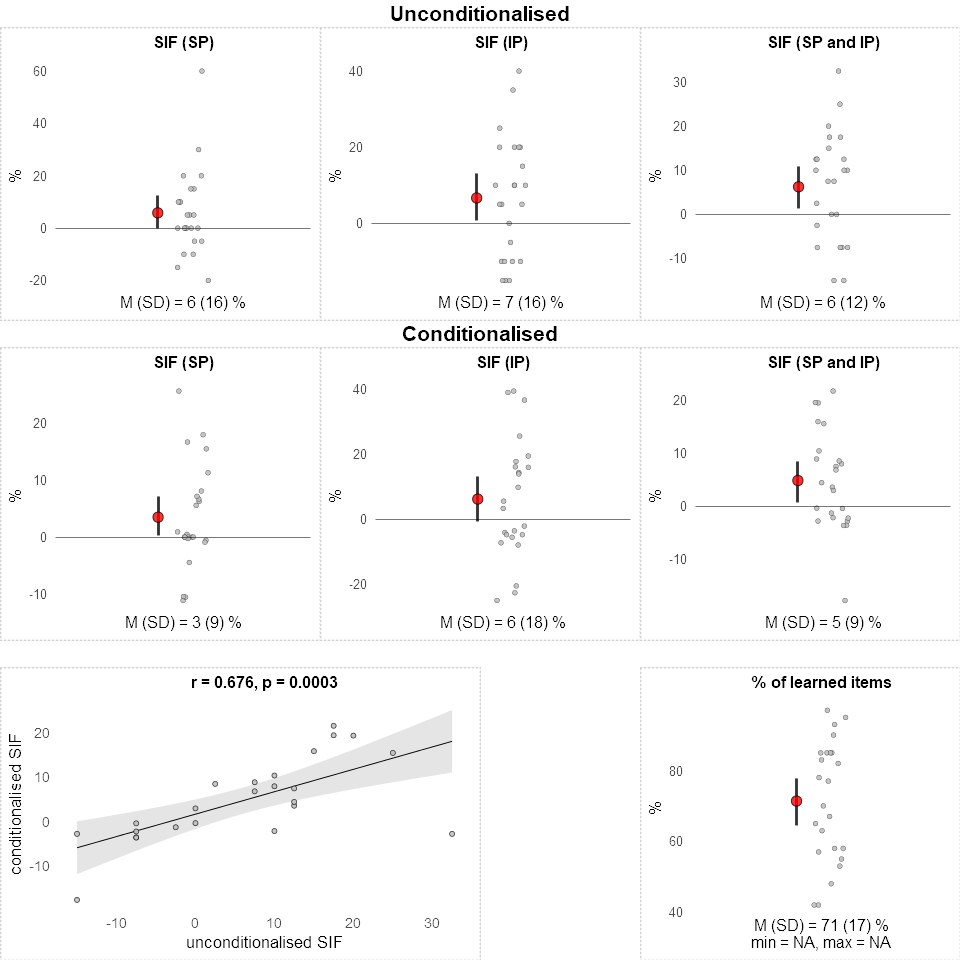

In [7]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 8, repr.plot.height = 8) 
# 1. Unconditionalised SP SIF
p10 <- plotResults(dataTNT, dataTNT$spSIFuc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFuc"], dscrTNT["std.dev","spSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 2. Unconditionalised IP SIF
p11 <- plotResults(dataTNT, dataTNT$ipSIFuc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFuc"], dscrTNT["std.dev","ipSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 3. Unconditionalised SPIP SIF SP and IP
p12 <- plotResults(dataTNT, dataTNT$spipSIFuc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFuc"], dscrTNT["std.dev","spipSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 4. Conditionalised SP SIF
p13 <- plotResults(dataTNT, dataTNT$spSIFc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFc"], dscrTNT["std.dev","spSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 5. Conditionalised IP SIF
p14 <- plotResults(dataTNT, dataTNT$ipSIFc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFc"], dscrTNT["std.dev","ipSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 6. Conditionalised SIF SP and IP
p15 <- plotResults(dataTNT, dataTNT$spipSIFc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFc"], dscrTNT["std.dev","spipSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 7. Relationship between conditionalised and unconditionalised SIFs
corr.SIF <- rcorr(dataTNT$spipSIFuc, dataTNT$spipSIFc)
resTxt  <- sprintf("r = %.3f, p = %.4f", corr.SIF$r[2], corr.SIF$P[2])
p16     <- plotCorrelation(dataTNT, dataTNT$spipSIFuc, dataTNT$spipSIFc, 
                           "unconditionalised SIF", "conditionalised SIF", resTxt, 1, 10)
# 8. % of learned (included in analysis) items
p17 <- plotResults(dataTNT, dataTNT$criterion, 1, "% of learned items", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%\nmin = %.0f, max = %.0f", 
                           dscrTNT["mean","criterion"], dscrTNT["std.dev","criterion"], 
                           dscrTNT["min","criterion"], dscrTNT["max","criterion"]))

## Put plots in a grid and display
grid.arrange(arrangeGrob(p10, p11, p12, top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(p13, p14, p15, top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1),
             arrangeGrob(p16, p17, top="", layout_matrix = rbind(c(1,1,1,NA,2,2))))

## SIF effect

In [8]:
# SIF effect (conditionalised, SP and IP)
# ----------------------------------------------------------------------
# http://www.sthda.com/english/wiki/one-sample-t-test-in-r
# Since the sample size is not large enough (less than 30, central limit theorem), we need to check whether 
# the data follow a normal distribution.
# It's possible to use the Shapiro-Wilk normality test and to look at the normality plot.
# 
# Shapiro-Wilk test:
#   Null hypothesis: the data are normally distributed
# Alternative hypothesis: the data are not normally distributed
shapiro.test(dataTNT$spipSIFc)

# SIF data are normally  distributed! Can do t.test. Otherwise would need to to wilcox.test
t.SIFc <- t.test(dataTNT$spipSIFc, mu = 0, alternative = "two.sided")
t.SIFc
sprintf("SIF effect: t(%d) = %.2f, p = %.3f", t.SIFc$parameter, t.SIFc$statistic, t.SIFc$p.value)


	Shapiro-Wilk normality test

data:  dataTNT$spipSIFc
W = 0.94945, p-value = 0.2636



	One Sample t-test

data:  dataTNT$spipSIFc
t = 2.5519, df = 23, p-value = 0.01782
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.9182781 8.7805936
sample estimates:
mean of x 
 4.849436 


[1] "SIF effect: t(23) = 2.55, p = 0.018"

# Outliers

[1] "SSRT outliers:0; SIF outliers: 0"

[1] "Bi-variate outliers: 1"

      SSRT       SIF
9 443.1415 -17.70833


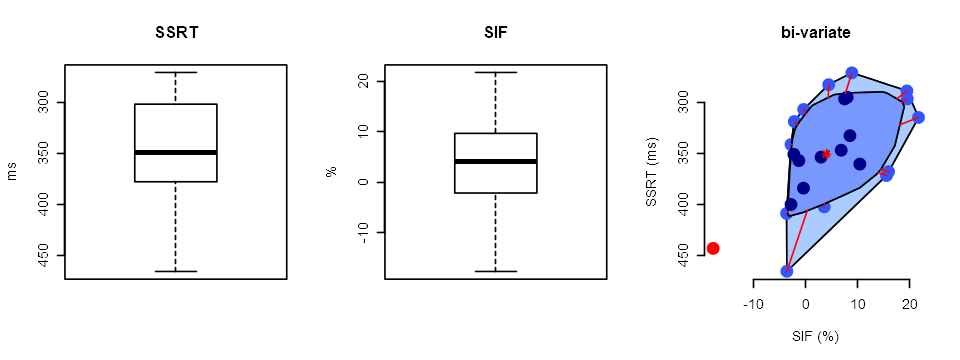

In [9]:
# ==================================================================
# SSRT and SIF OUTLIERS
# ==================================================================
SSRT <- dataSSTsubj$SSRT
SIF  <- dataTNT$spipSIFc

layout(matrix(c(1,2,3), ncol = 3, byrow = TRUE))
options(repr.plot.width = 8, repr.plot.height = 3) # change plot size

# Univariate, boxplot method
# ------------------------------------
bpSSRT <- boxplot(SSRT, main = 'SSRT', ylab = 'ms', ylim = rev(range(SSRT))) 
bpSIF  <- boxplot(SIF, main = 'SIF', ylab = '%')

# Bi-variate, bogplot method
# ------------------------------------
# A bagplot is a bivariate generalization of the  boxplot. A bivariate boxplot. 
bpl  <- compute.bagplot(SSRT, SIF)
oBiv <- which(data.frame(SSRT,SIF) == bpl$pxy.outlier)
bagplot(SIF, SSRT, cex = 2, ylim = rev(range(SSRT)), ylab = 'SSRT (ms)', xlab = 'SIF (%)', main = 'bi-variate')

# Report results
# ------------------------------------
sprintf("SSRT outliers:%d; SIF outliers: %d", length(bpSSRT$out), length(bpSIF$out))
sprintf("Bi-variate outliers: %d", length(oBiv))
print(data.frame(SSRT,SIF)[oBiv, ])

# SSRT and SIF correlation

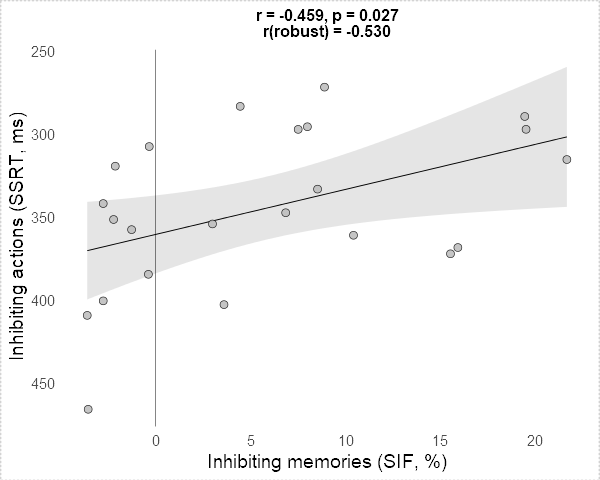

In [10]:
# ==================================================================
# SSRT and SIF CORRELATION
# ==================================================================
sNR <- dataTNT$sNR
res.Inhibition <- data.frame(sNR, SSRT,SIF)

res.Inhibition <- subset(res.Inhibition, sNR != oBiv)

corr.SSRT.SIF <- rcorr(res.Inhibition$SIF, res.Inhibition$SSRT)
# The default "auto" selects from "donostah", "mcd", and "pairwiseQC" with the goal of producing a good estimate 
# in a reasonable amount of time
corrRob.SSRT.SIF <- covRob(cbind(res.Inhibition$SIF, res.Inhibition$SSRT), corr = TRUE, estim = "auto")

resTxt  <- sprintf("r = %.3f, p = %.3f\nr(robust) = %.3f", 
                   corr.SSRT.SIF$r[2], corr.SSRT.SIF$P[2],corrRob.SSRT.SIF$cov[2])
options(repr.plot.width = 5, repr.plot.height = 4) # change plot size
plotCorrelation(res.Inhibition, res.Inhibition$SIF, res.Inhibition$SSRT, 
                "Inhibiting memories (SIF, %)", "Inhibiting actions (SSRT, ms)", resTxt, 1.8, 11) + 
  scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)

In [11]:
# reset to defult plot size
options(repr.plot.width = 7, repr.plot.height = 7)